https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1


https://towardsdatascience.com/similarity-metrics-in-nlp-acc0777e234c 

https://www.youtube.com/watch?v=Ey81KfQ3PQU


Model semantic search: 'multi-qa-MiniLM-L6-cos-v1'

Model assymetric : 'msmarco-MiniLM-L-6-v3'

In [2]:
# import sys
# import os

# # Add the 'Functions' directory to the Python path
# sys.path.append(os.path.abspath('../../Functions'))

from src.db.connection import *
from src.pre_processing.data_cleaning import *
from src.pre_processing.features_creation.features_creation_baseline import *
from src.pre_processing.features_creation.features_creation_dummies import *
from src.modelling_pipelines.modelling_functions.Logistic_regression  import *
from src.modelling_pipelines.modelling_functions.model_evaluation import *
from src.pre_processing.features_creation.features_creation_transformed_nlp import *
from notebooks.BERT.bert import *
from src.modelling_pipelines.final_model_pipeline import *

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import xgboost as xgb
# Import argsort
from numpy import argsort
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt

In [3]:
protocols = pd.read_csv('./BERT/protocols_to_bert.csv')
protocols

,A1,A2,A3,A4,A5,A6,R0,R1,R2,R3,R4,R5,R6,R7
0,Cefaleia crónica,Distúrbios do equilíbrio com quedas frequentes,Doenças neuromusculares e genéticas,Distúrbio de aprendizagem,Demência com dúvida diagnóstica,Doença desmielinizante,Nervosismo sem indicação neurológica,Queixas somáticas sem explicação médica,Eplepsia controlada com medicação,Alterações do sono,Prevenção primária das doenças cerebrovasculares,Cefaleia primária típica,Paralisia facial periférica,Neurocisticercose calcificada
1,Cefaleia refratária,Distonia,dores neuropáticas refratárias,Retardo psicomotor,Demência rapidamente progressiva,Esclerose múltipla,Sinais de lesão no sistema nervoso central (SN...,NaN,Um a dois anos de monoterapia,Insônia,Prevenção secundária das doenças cerebrovascul...,Enxaqueca,NaN,Lesão cronica
2,Enxaqueca persistente,Parkinson,parestesias recorrentes e/ou progressivas,NaN,NaN,Mielite transversa,NaN,NaN,NaN,NaN,NaN,Tensional,NaN,lesão inativa
3,NaN,Tremor essencial,paraplegias e paresias,NaN,NaN,Doença de Devic,NaN,NaN,NaN,NaN,NaN,em salvas,NaN,NaN
4,NaN,Ataxia ou descoordenação motora,esclerose lateral amiotrófica,NaN,NaN,Leucoencefalopatia multifocal progressiva,NaN,NaN,NaN,NaN,NaN,Cefaleia episódica sem abuso medicamentoso,NaN,NaN
5,NaN,"Coreia, balismo ou movimentos involuntários",suspeita de miopatias,NaN,NaN,Neurite óptica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,miastenia graves e outros transtornos neuromus...,NaN,NaN,Leucodistrofias,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,"amiotrofias espinhais e síndromes correlatas, ...",NaN,NaN,Síndrome de Van der Knaap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,doenças neurogenéticas,NaN,NaN,Doença neuroimunológica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,Doença autoimune,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
baseline = protocols.columns.to_list()

In [5]:
# # 1. Data cleaning
reference = []

for col in baseline:
    
    protocols2 = protocols.copy()
    protocols2 = protocols2[[col]].dropna()

    lower_text(protocols2,col, col)
    remove_stop_words(protocols2,col, col)
    spacy_lemmatizer(protocols2,col, col)

    reference.append(list(protocols2[col].dropna()))

    
# [reference.append(list(spacy_lemmatizer(remove_stop_words(lower_text(protocols[[col]].copy().dropna(), col), col), col)[col].dropna())) for col in baseline]

reference

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-d

[['cefaleia crónico', 'cefaleia refratária', 'enxaqueca persistente'],
 ['distúrbio equilíbrio queda frequente',
  'distonia',
  'parkinson',
  'tremor essencial',
  'ataxio descoordenação motoro',
  'coreia balismo movimento involuntário'],
 ['doença neuromuscular genético',
  'dor neuropático refratário',
  'parestesia recorrente e/ou progressivo',
  'paraplegia paresio',
  'esclerose lateral amiotrófico',
  'suspeito miopatia',
  'miastenia grave outro transtorno neuromuscular',
  'amiotrofia espinhal síndromes correlato polineuropatia outro transtorno sistema nervoso periférico snp',
  'doença neurogenético'],
 ['distúrbio aprendizagem', 'retardo psicomotor'],
 ['demência dúvido diagnósticar', 'demência rapidamente progressivo'],
 ['doença desmielinizante',
  'esclerose múltiplo',
  'mielite transverso',
  'doença devic',
  'leucoencefalopatia multifocal progressivo',
  'neurite óptico',
  'leucodistrofia',
  'síndrome van der knaap',
  'doença neuroimunológico',
  'doença autoimun

In [6]:
alertP1 = connection('credentials.txt')
data = pre_process(alertP1)


Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
260


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# model_name = 'pucpr/biobertpt-all'
model_name = 'sentence-transformers/msmarco-MiniLM-L-6-v3'

In [8]:
from sentence_transformers import SentenceTransformer

In [9]:
data = bert_split_referrals(data, reference, model_name = 'sentence-transformers/msmarco-MiniLM-L-6-v3')
data

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gabrielabib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,4_score,5_score,6_score,7_score,8_score,9_score,10_score,11_score,12_score,13_score
0,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,0.250608,0.430345,0.219032,0.064663,0.209035,0.341361,0.220140,0.240939,0.008430,0.292257
1,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,0.237314,0.395145,0.206825,0.335640,0.279991,0.269846,0.285896,0.288742,0.065241,0.348118
2,BSEZF,LLCBVJI,LOHHLTRS,SCCABHA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,53,...,0.224389,0.390945,0.201482,0.129487,0.397659,0.279731,0.109168,0.263201,0.041125,0.236320
3,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0.318833,0.358676,0.342695,0.177090,0.270482,0.333073,0.211397,0.306844,0.117525,0.371669
4,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0.240041,0.725448,0.329573,0.216607,0.447032,0.338462,0.313775,0.304138,0.308378,0.308645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,FFDSBH,MILLLCJ,LSHUVULH,ZESCCSSF,3152401,UCSP CORROIOS,CS/USF,2,Prioritário,0,...,0.290637,0.357977,0.337897,0.252078,0.264631,0.437410,0.300674,0.282145,0.270234,0.354361
1605,EBBCSA,"I,IJME+LI",LSHVHLLH,ZESBAHAD,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,3,Normal,0,...,0.401923,0.418878,0.398244,0.349661,0.319653,0.335633,0.292075,0.388273,0.219343,0.309452
1606,ZHZFA,ILBIBCL,LSHVHLHP,ZESBFBCB,3152400,CORROIOS (SEDE),CS/USF,3,Normal,0,...,0.425244,0.352883,0.372743,0.284069,0.582976,0.438269,0.307501,0.402174,0.472891,0.314858
1607,FDSADA,IIJMMNJ,LSHVHSUR,ZESGGDFH,3150572,USF MONTE DA CAPARICA,CS/USF,,unknown,7,...,0.353826,0.431474,0.314543,0.398472,0.274035,0.547317,0.305567,0.417087,0.173661,0.420819


## XGboost

In [10]:
# alertP1_simplified.describe()
import xgboost as xgb


In [11]:
def precision_at_k(y_true, y_pred, k):
    y_true = y_true.to_numpy()
    # Get the indices of the top k predictions
    top_k_indices = np.argsort(y_pred)[-k:]
    # Get the top k predictions
    top_k_predictions = y_true[top_k_indices]
    # Calculate precision@k
    precision = np.sum(top_k_predictions) / k
    return precision

In [12]:
def xgb_classifier(features, target):
    
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=16,shuffle=False)

    # X_train['before_accepted'] = X_train['before_accepted'].astype('category')
    # X_test['before_accepted'] = X_test['before_accepted'].astype('category')

    # Convert data into DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
    dtest = xgb.DMatrix(X_test, enable_categorical = True)

    # Set parameters for the XGBoost model
    param = {
        'max_depth': 3,
        'eta': 0.3,
        'objective': 'binary:logistic',
        'seed': 16
    }

    # Train the model
    num_round = 10
    bst = xgb.train(param, dtrain, num_round)

    # Make preictions on the train set
    y_pred_train = bst.predict(dtrain)
    # Make predictions on the test set
    y_pred_test = bst.predict(dtest)
    
    return y_pred_train, y_pred_test, bst.get_score(), X_train, X_test, y_train, y_test    

In [13]:
data

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,4_score,5_score,6_score,7_score,8_score,9_score,10_score,11_score,12_score,13_score
0,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,0.250608,0.430345,0.219032,0.064663,0.209035,0.341361,0.220140,0.240939,0.008430,0.292257
1,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,0.237314,0.395145,0.206825,0.335640,0.279991,0.269846,0.285896,0.288742,0.065241,0.348118
2,BSEZF,LLCBVJI,LOHHLTRS,SCCABHA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,53,...,0.224389,0.390945,0.201482,0.129487,0.397659,0.279731,0.109168,0.263201,0.041125,0.236320
3,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0.318833,0.358676,0.342695,0.177090,0.270482,0.333073,0.211397,0.306844,0.117525,0.371669
4,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0.240041,0.725448,0.329573,0.216607,0.447032,0.338462,0.313775,0.304138,0.308378,0.308645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1604,FFDSBH,MILLLCJ,LSHUVULH,ZESCCSSF,3152401,UCSP CORROIOS,CS/USF,2,Prioritário,0,...,0.290637,0.357977,0.337897,0.252078,0.264631,0.437410,0.300674,0.282145,0.270234,0.354361
1605,EBBCSA,"I,IJME+LI",LSHVHLLH,ZESBAHAD,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,3,Normal,0,...,0.401923,0.418878,0.398244,0.349661,0.319653,0.335633,0.292075,0.388273,0.219343,0.309452
1606,ZHZFA,ILBIBCL,LSHVHLHP,ZESBFBCB,3152400,CORROIOS (SEDE),CS/USF,3,Normal,0,...,0.425244,0.352883,0.372743,0.284069,0.582976,0.438269,0.307501,0.402174,0.472891,0.314858
1607,FDSADA,IIJMMNJ,LSHVHSUR,ZESGGDFH,3150572,USF MONTE DA CAPARICA,CS/USF,,unknown,7,...,0.353826,0.431474,0.314543,0.398472,0.274035,0.547317,0.305567,0.417087,0.173661,0.420819


In [14]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns

y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, auc, confusion_matrix, cohen_kappa_score

def evaluate_thresholds(y_pred_train, y_train, y_pred_test, y_test, metrics = "test", k=211):
    #Precion@k
    def precision_at_k(y_true, y_pred, k):
        y_true = y_true.to_numpy()
        # Get the indices of the top k predictions
        top_k_indices = np.argsort(y_pred)[-k:]
        # Get the top k predictions
        top_k_predictions = y_true[top_k_indices]
        # Calculate precision@k
        precision = np.sum(top_k_predictions) / k
        return precision

    if metrics == "test":
        # Default threshold (0.5)
        default_threshold = 0.5
        default_y_pred_binary = (y_pred_test >= default_threshold).astype(int)
        default_accuracy = accuracy_score(y_test, default_y_pred_binary)
        default_recall = recall_score(y_test, default_y_pred_binary)
        default_precision = precision_score(y_test, default_y_pred_binary)
        default_precision_at_k = precision_at_k(y_test, default_y_pred_binary, k)
        
        # Define thresholds
    

        # Precision-Recall trade-off
        precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
        f1_scores = 2 * precision * recall / (precision + recall)
        best_index = pd.Series(f1_scores).idxmax()
        pr_threshold = thresholds[best_index]
        pr_y_pred_binary = (y_pred_test >= pr_threshold).astype(int)
        pr_accuracy = accuracy_score(y_test, pr_y_pred_binary)
        pr_recall = recall_score(y_test, pr_y_pred_binary)
        pr_precision = precision_score(y_test, pr_y_pred_binary)
        pr_precision_at_k = precision_at_k(y_test, pr_y_pred_binary, k)
        
        thresholds = np.linspace(0, 1, 100)

        # Balanced Accuracy
        cms = [confusion_matrix(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
        specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
        balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
        ba_threshold = thresholds[np.argmax(balanced_accuracy)]
        ba_y_pred_binary = (y_pred_test >= ba_threshold).astype(int)
        ba_accuracy = accuracy_score(y_test, ba_y_pred_binary)
        ba_recall = recall_score(y_test, ba_y_pred_binary)
        ba_precision = precision_score(y_test, ba_y_pred_binary)
        ba_precision_at_k = precision_at_k(y_test, ba_y_pred_binary,k)
        
        # Cohen's Kappa
        kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        kappa_threshold = thresholds[np.argmax(kappas)]
        kappa_y_pred_binary = (y_pred_test >= kappa_threshold).astype(int)
        kappa_kappa = cohen_kappa_score(y_test, kappa_y_pred_binary)
        kappa_accuracy = accuracy_score(y_test, kappa_y_pred_binary)
        kappa_recall = recall_score(y_test, kappa_y_pred_binary)
        kappa_precision = precision_score(y_test, kappa_y_pred_binary)
        kappa_precision_at_k = precision_at_k(y_test, kappa_y_pred_binary, k)

        # Limit to K
        len_train_k = int(len(y_pred_train)*0.65)
        limit_to_k_threshold = np.sort(y_pred_train)[-len_train_k]
        limit_to_k_y_pred_binary = (y_pred_test >= limit_to_k_threshold).astype(int)
        limit_to_k_accuracy = accuracy_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_recall = recall_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_precision = precision_score(y_test, limit_to_k_y_pred_binary)
        limit_to_k_precision_at_k = precision_at_k(y_test, limit_to_k_y_pred_binary, k)

    else:
        # Default threshold (0.5)
        default_threshold = 0.5
        default_y_pred_binary = (y_pred_train >= default_threshold).astype(int)
        default_accuracy = accuracy_score(y_train, default_y_pred_binary)
        default_recall = recall_score(y_train, default_y_pred_binary)
        default_precision = precision_score(y_train, default_y_pred_binary)
        default_precision_at_k = precision_at_k(y_train, default_y_pred_binary, k)
        
        # Define thresholds
    

        # Precision-Recall trade-off
        precision, recall, thresholds = precision_recall_curve(y_train, y_pred_train)
        f1_scores = 2 * precision * recall / (precision + recall)
        best_index = pd.Series(f1_scores).idxmax()
        pr_threshold = thresholds[best_index]
        pr_y_pred_binary = (y_pred_train >= pr_threshold).astype(int)
        pr_accuracy = accuracy_score(y_train, pr_y_pred_binary)
        pr_recall = recall_score(y_train, pr_y_pred_binary)
        pr_precision = precision_score(y_train, pr_y_pred_binary)
        pr_precision_at_k = precision_at_k(y_train, pr_y_pred_binary, k)
        
        thresholds = np.linspace(0, 1, 100)

        # Balanced Accuracy
        cms = [confusion_matrix(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        sensitivity = [cm[1, 1] / (cm[1, 1] + cm[1, 0]) for cm in cms]
        specificity = [cm[0, 0] / (cm[0, 0] + cm[0, 1]) for cm in cms]
        balanced_accuracy = [(s + sp) / 2 for s, sp in zip(sensitivity, specificity)]
        ba_threshold = thresholds[np.argmax(balanced_accuracy)]
        ba_y_pred_binary = (y_pred_train >= ba_threshold).astype(int)
        ba_accuracy = accuracy_score(y_train, ba_y_pred_binary)
        ba_recall = recall_score(y_train, ba_y_pred_binary)
        ba_precision = precision_score(y_train, ba_y_pred_binary)
        ba_precision_at_k = precision_at_k(y_train, ba_y_pred_binary,k)
        
        # Cohen's Kappa
        kappas = [cohen_kappa_score(y_train, (y_pred_train >= t).astype(int)) for t in thresholds]
        kappa_threshold = thresholds[np.argmax(kappas)]
        kappa_y_pred_binary = (y_pred_train >= kappa_threshold).astype(int)
        kappa_kappa = cohen_kappa_score(y_train, kappa_y_pred_binary)
        kappa_accuracy = accuracy_score(y_train, kappa_y_pred_binary)
        kappa_recall = recall_score(y_train, kappa_y_pred_binary)
        kappa_precision = precision_score(y_train, kappa_y_pred_binary)
        kappa_precision_at_k = precision_at_k(y_train, kappa_y_pred_binary, k)

        # Limit to K
        len_train_k = int(len(y_pred_train)*0.65)
        limit_to_k_threshold = np.sort(y_pred_train)[-len_train_k]
        limit_to_k_y_pred_binary = (y_pred_train >= limit_to_k_threshold).astype(int)
        limit_to_k_accuracy = accuracy_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_recall = recall_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_precision = precision_score(y_train, limit_to_k_y_pred_binary)
        limit_to_k_precision_at_k = precision_at_k(y_train, limit_to_k_y_pred_binary, k)

    # Create output dataframe
    data = {
        'Analysis': ['Default', 'Precision-Recall trade-off', 'Balanced Accuracy', "Cohen's Kappa", 'Limit to K'],
        'Threshold': [round(default_threshold, 2), round(pr_threshold, 2), round(ba_threshold, 2), round(kappa_threshold, 2), round(limit_to_k_threshold, 2)],
        'Accuracy': [round(default_accuracy, 2), round(pr_accuracy, 2), round(ba_accuracy, 2), round(kappa_accuracy, 2), round(limit_to_k_accuracy, 2)],
        'Recall': [round(default_recall, 2), round(pr_recall, 2), round(ba_recall, 2), round(kappa_recall, 2), round(limit_to_k_recall, 2)],
        'Precision': [round(default_precision, 2), round(pr_precision, 2), round(ba_precision, 2), round(kappa_precision, 2), round(limit_to_k_precision, 2)],
        'Precision@211': [round(default_precision_at_k, 2), round(pr_precision_at_k, 2), round(ba_precision_at_k, 2), round(kappa_precision_at_k, 2), round(limit_to_k_precision_at_k, 2)]
    }
    
    df = pd.DataFrame(data)
    return df



In [16]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.82,0.97,0.80,0.88
1,Precision-Recall trade-off,0.58,0.84,0.93,0.85,0.91
2,Balanced Accuracy,0.69,0.80,0.79,0.91,0.93
3,Cohen's Kappa,0.61,0.83,0.90,0.86,0.91
4,Limit to K,0.65,0.82,0.84,0.89,0.91


In [17]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.68,0.97,0.68,0.71
1,Precision-Recall trade-off,0.58,0.66,0.86,0.69,0.69
2,Balanced Accuracy,0.69,0.67,0.72,0.76,0.74
3,Cohen's Kappa,0.61,0.69,0.83,0.73,0.73
4,Limit to K,0.65,0.68,0.77,0.75,0.74


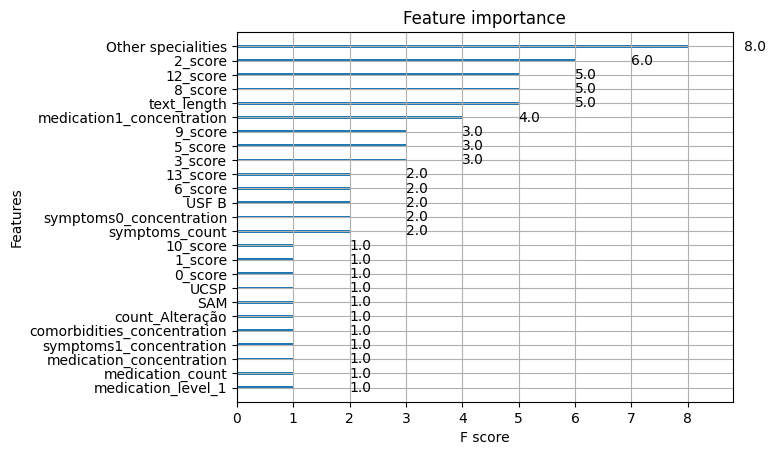

In [18]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 82 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_DOENTE                    1609 non-null   object        
 1   PROCESSO                     1609 non-null   object        
 2   COD_REFERENCIA               1609 non-null   object        
 3   COD_PZ                       1609 non-null   object        
 4   COD_UNID_SAUDE_PROV          1609 non-null   int64         
 5   UNID_PROV                    1609 non-null   object        
 6   TIPO_UNID                    1609 non-null   object        
 7   COD_CTH_PRIOR                1609 non-null   object        
 8   CTH_PRIOR                    1609 non-null   object        
 9   COD_MOTIVO_RECUSA            1609 non-null   int64         
 10  DES_MOTIVO_RECUSA            1609 non-null   object        
 11  COD_ESPECIALIDADE            1609 non-null 

In [24]:
# columns_bert = ['accep_prot_0', 'accep_prot_1', 'accep_prot_2', 'accep_prot_3', 'accep_prot_4', 'accep_prot_5', 'rej_prot_0', 'rej_prot_1', 'rej_prot_2', 'rej_prot_3', 'rej_prot_4', 'rej_prot_5', 'rej_prot_6', 'rej_prot_7']
# columns_bert = ['acc_prot_0','acc_prot_1','acc_prot_2','acc_prot_3','acc_prot_4','acc_prot_5','rej_prot_0','rej_prot_1','rej_prot_2','rej_prot_3','rej_prot_4','rej_prot_5','rej_prot_6','rej_prot_7']
# desirable = ['0_score','1_score','2_score','3_score','4_score','5_score','6_score','7_score']

desirable = ['0_score','1_score','2_score','3_score','4_score','5_score','6_score','7_score','8_score','9_score','10_score','11_score','12_score','13_score']
data[desirable].describe()

,0_score,1_score,2_score,3_score,4_score,5_score,6_score,7_score,8_score,9_score,10_score,11_score,12_score,13_score
count,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000,1609.000000
mean,0.293335,0.366071,0.362067,0.268869,0.325324,0.382068,0.314720,0.300190,0.317933,0.332618,0.284146,0.340304,0.178109,0.330507
std,0.112788,0.102611,0.082276,0.069603,0.102831,0.095582,0.109325,0.115956,0.085772,0.119936,0.092575,0.095642,0.088354,0.083603
min,-0.037176,0.086008,0.098522,-0.024949,0.000980,0.112181,-0.046205,-0.097012,-0.015442,-0.031059,-0.058690,0.066371,-0.105195,0.047016
25%,0.237465,0.290825,0.303780,0.230177,0.253060,0.329731,0.235662,0.239321,0.276569,0.268949,0.229207,0.288742,0.113619,0.285925
50%,0.279113,0.391306,0.361239,0.279000,0.319434,0.380027,0.318168,0.310636,0.314722,0.318394,0.285896,0.326864,0.183687,0.339704
75%,0.337517,0.406086,0.404751,0.306888,0.383931,0.417537,0.388556,0.361197,0.371310,0.389550,0.342713,0.388166,0.239333,0.374187
max,1.000000,1.000000,1.000000,0.572718,0.717770,1.000000,0.652834,0.698010,0.614846,0.770022,0.820864,1.000000,0.553595,0.718735


In [28]:
data2 = data.copy()


# Calculate quartiles for each score column
score_cols = desirable  # replace with your actual column names
quartile_labels = ['1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile', '90_quantile']
for col in score_cols:
    quartile_bins = [0, data2[col].quantile(0.25), data2[col].quantile(0.5), data2[col].quantile(0.75), data2[col].quantile(0.90), float('inf')]
    data2[col + '_quartile'] = pd.cut(data2[col], bins=quartile_bins, labels=quartile_labels)
    # data2[col + '_flag'] = (data2[col + '_quartile'] == quartile_labels[0]).astype(int)


In [29]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 0 to 1608
Data columns (total 96 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_DOENTE                    1609 non-null   object        
 1   PROCESSO                     1609 non-null   object        
 2   COD_REFERENCIA               1609 non-null   object        
 3   COD_PZ                       1609 non-null   object        
 4   COD_UNID_SAUDE_PROV          1609 non-null   int64         
 5   UNID_PROV                    1609 non-null   object        
 6   TIPO_UNID                    1609 non-null   object        
 7   COD_CTH_PRIOR                1609 non-null   object        
 8   CTH_PRIOR                    1609 non-null   object        
 9   COD_MOTIVO_RECUSA            1609 non-null   int64         
 10  DES_MOTIVO_RECUSA            1609 non-null   object        
 11  COD_ESPECIALIDADE            1609 non-null 

In [30]:
results = pd.DataFrame({'quartile': quartile_labels})

# columns_quartile = ['0_score_quartile','1_score_quartile','2_score_quartile','3_score_quartile','4_score_quartile','5_score_quartile','6_score_quartile','7_score_quartile']

columns_quartile = ['0_score_quartile','1_score_quartile','2_score_quartile','3_score_quartile','4_score_quartile','5_score_quartile','6_score_quartile','7_score_quartile','8_score_quartile','9_score_quartile','10_score_quartile','11_score_quartile','12_score_quartile','13_score_quartile']

for i , col in enumerate(columns_quartile):
    teste = data2.groupby(col)['result'].sum().reset_index()
    teste.rename(columns={'result': 'sum_'+str(i)}, inplace=True)
    teste2 = data2.groupby(col)['result'].count().reset_index()
    teste2.rename(columns={'result': 'count_'+str(i)}, inplace=True)
    results = results.merge(teste, left_on='quartile', right_on= col, how='left')
    results = results.drop(col,axis=1)
    results = results.merge(teste2, left_on='quartile', right_on= col, how='left')
    results = results.drop(col,axis=1)
    results[desirable[i]] = results['sum_'+str(i)]/results['count_'+str(i)]
    results = results.drop(['sum_'+str(i),'count_'+str(i)],axis=1)
  


results

,quartile,0_score,1_score,2_score,3_score,4_score,5_score,6_score,7_score,8_score,9_score,10_score,11_score,12_score,13_score
0,1st Quartile,0.673367,0.456576,0.436725,0.716418,0.485437,0.699752,0.460154,0.690537,0.646617,0.695000,0.696742,0.537736,0.462766,0.699752
1,2nd Quartile,0.538627,0.743781,0.713930,0.721393,0.720102,0.726368,0.716418,0.721393,0.462687,0.485075,0.475845,0.738182,0.679104,0.763682
2,3rd Quartile,0.813609,0.739872,0.783582,0.500000,0.721393,0.517413,0.776119,0.537313,0.781095,0.771144,0.752577,0.743781,0.738806,0.522388
3,4th Quartile,0.784232,0.798851,0.767635,0.796680,0.792531,0.771784,0.775934,0.788382,0.858921,0.788382,0.813278,0.834025,0.853755,0.751037
4,90_quantile,0.689441,0.807453,0.844720,0.788820,0.838509,0.813665,0.739130,0.770186,0.807453,0.776398,0.826087,0.689441,0.812081,0.739130
